In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer


In [2]:
animes = pd.read_csv('anime.csv', index_col="MAL_ID",
                     usecols=['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 
                              'Episodes', 'Premiered', 'Studios',
                              'Source', 'Rating', 'Ranked', 'Popularity'])
animes

,Name,Score,Genres,Type,Episodes,Premiered,Studios,Source,Rating,Ranked,Popularity
MAL_ID,,,,,,,,,,,
1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,Spring 1998,Sunrise,Original,R - 17+ (violence & profanity),28.0,39
5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,Unknown,Bones,Original,R - 17+ (violence & profanity),159.0,518
6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,26,Spring 1998,Madhouse,Manga,PG-13 - Teens 13 or older,266.0,201
7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,26,Summer 2002,Sunrise,Original,PG-13 - Teens 13 or older,2481.0,1467
8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,52,Fall 2004,Toei Animation,Manga,PG - Children,3710.0,4369
...,...,...,...,...,...,...,...,...,...,...,...
48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",ONA,Unknown,Unknown,Unknown,Novel,Unknown,Unknown,13116
48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",TV,Unknown,Unknown,Passione,Manga,Unknown,Unknown,17562
48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",TV,Unknown,Summer 2021,Unknown,Visual novel,R - 17+ (violence & profanity),Unknown,17558


In [3]:
for numbers in ["Score", "Episodes", "Ranked", "Popularity"]:
    animes[numbers] = pd.to_numeric(animes[numbers], errors="coerce", downcast="float")

In [4]:
animes.describe(include=np.number)

,Score,Episodes,Ranked,Popularity
count,12421.000000,17046.000000,15800.000000,17562.000000
mean,6.509999,11.525519,7895.209473,8763.453125
std,0.886717,47.348640,4557.318359,5059.327148
min,1.850000,1.000000,0.000000,0.000000
25%,5.930000,1.000000,3944.000000,4383.500000
50%,6.520000,2.000000,7896.000000,8762.500000
75%,7.140000,12.000000,11845.250000,13145.000000
max,9.190000,3057.000000,15780.000000,17565.000000


In [5]:
animes.Genres = animes.Genres.str.split(', ')

## OHE for Genres

### get dummies

In [6]:
one_hot_encoded = pd.get_dummies(animes['Genres'].apply(pd.Series).stack()).groupby(level=0).max()
df = pd.concat([animes, one_hot_encoded], axis=1)
df = df.drop('Genres', axis=1)

df

,Name,Score,Type,Episodes,Premiered,Studios,Source,Rating,Ranked,Popularity,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,Yuri
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,TV,26.0,Spring 1998,Sunrise,Original,R - 17+ (violence & profanity),28.0,39.0,...,False,True,False,False,False,False,False,False,False,False
5,Cowboy Bebop: Tengoku no Tobira,8.39,Movie,1.0,Unknown,Bones,Original,R - 17+ (violence & profanity),159.0,518.0,...,False,True,False,False,False,False,False,False,False,False
6,Trigun,8.24,TV,26.0,Spring 1998,Madhouse,Manga,PG-13 - Teens 13 or older,266.0,201.0,...,False,False,False,False,False,False,False,False,False,False
7,Witch Hunter Robin,7.27,TV,26.0,Summer 2002,Sunrise,Original,PG-13 - Teens 13 or older,2481.0,1467.0,...,False,False,False,False,True,False,False,False,False,False
8,Bouken Ou Beet,6.98,TV,52.0,Fall 2004,Toei Animation,Manga,PG - Children,3710.0,4369.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,Daomu Biji Zhi Qinling Shen Shu,NaN,ONA,NaN,Unknown,Unknown,Novel,Unknown,NaN,13116.0,...,False,False,False,False,True,False,False,False,False,False
48483,Mieruko-chan,NaN,TV,NaN,Unknown,Passione,Manga,Unknown,NaN,17562.0,...,False,False,False,False,True,False,False,False,False,False
48488,Higurashi no Naku Koro ni Sotsu,NaN,TV,NaN,Summer 2021,Unknown,Visual novel,R - 17+ (violence & profanity),NaN,17558.0,...,False,False,False,False,True,True,False,False,False,False


In [7]:
df.columns

Index(['Name', 'Score', 'Type', 'Episodes', 'Premiered', 'Studios', 'Source',
       'Rating', 'Ranked', 'Popularity', 'Action', 'Adventure', 'Cars',
       'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game',
       'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object')

### MultiLabelBinarizer

In [8]:
mlb = MultiLabelBinarizer()
animes_gen = animes.join(pd.DataFrame(mlb.fit_transform(animes.pop("Genres")),
                          columns=mlb.classes_,
                          index=animes.index))

In [9]:
animes_gen

,Name,Score,Type,Episodes,Premiered,Studios,Source,Rating,Ranked,Popularity,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,Yuri
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,TV,26.0,Spring 1998,Sunrise,Original,R - 17+ (violence & profanity),28.0,39.0,...,0,1,0,0,0,0,0,0,0,0
5,Cowboy Bebop: Tengoku no Tobira,8.39,Movie,1.0,Unknown,Bones,Original,R - 17+ (violence & profanity),159.0,518.0,...,0,1,0,0,0,0,0,0,0,0
6,Trigun,8.24,TV,26.0,Spring 1998,Madhouse,Manga,PG-13 - Teens 13 or older,266.0,201.0,...,0,0,0,0,0,0,0,0,0,0
7,Witch Hunter Robin,7.27,TV,26.0,Summer 2002,Sunrise,Original,PG-13 - Teens 13 or older,2481.0,1467.0,...,0,0,0,0,1,0,0,0,0,0
8,Bouken Ou Beet,6.98,TV,52.0,Fall 2004,Toei Animation,Manga,PG - Children,3710.0,4369.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,Daomu Biji Zhi Qinling Shen Shu,NaN,ONA,NaN,Unknown,Unknown,Novel,Unknown,NaN,13116.0,...,0,0,0,0,1,0,0,0,0,0
48483,Mieruko-chan,NaN,TV,NaN,Unknown,Passione,Manga,Unknown,NaN,17562.0,...,0,0,0,0,1,0,0,0,0,0
48488,Higurashi no Naku Koro ni Sotsu,NaN,TV,NaN,Summer 2021,Unknown,Visual novel,R - 17+ (violence & profanity),NaN,17558.0,...,0,0,0,0,1,1,0,0,0,0


In [10]:
mlb.classes_

array(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons',
       'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts',
       'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police',
       'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri'], dtype=object)

In [11]:
genres = animes_gen[mlb.classes_]

## Clustering

In [12]:
def cluster(data, range_min, range_max, title):
    inertia = []
    for n_clusters in range(range_min,range_max):
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    plt.plot(range(range_min,range_max), inertia)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    _ = plt.title(title)

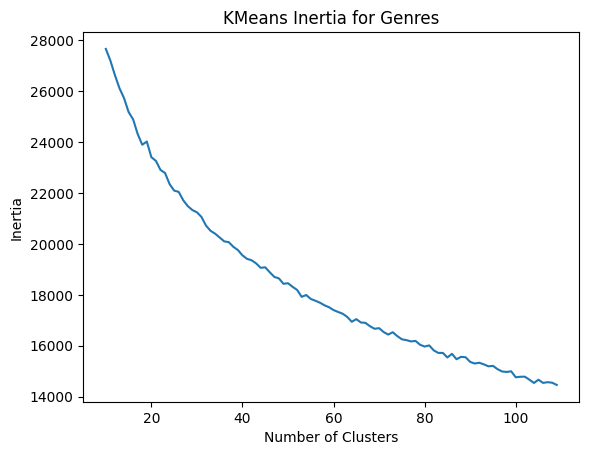

In [13]:
cluster(genres, 10, 110, "KMeans Inertia for Genres")

In [13]:
animes_ohe = pd.get_dummies(animes_gen, columns=["Type", "Rating"], dtype="int")
animes_ohe

,Name,Score,Episodes,Premiered,Studios,Source,Ranked,Popularity,Action,Adventure,...,Type_Special,Type_TV,Type_Unknown,Rating_G - All Ages,Rating_PG - Children,Rating_PG-13 - Teens 13 or older,Rating_R - 17+ (violence & profanity),Rating_R+ - Mild Nudity,Rating_Rx - Hentai,Rating_Unknown
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,26.0,Spring 1998,Sunrise,Original,28.0,39.0,1,1,...,0,1,0,0,0,0,1,0,0,0
5,Cowboy Bebop: Tengoku no Tobira,8.39,1.0,Unknown,Bones,Original,159.0,518.0,1,0,...,0,0,0,0,0,0,1,0,0,0
6,Trigun,8.24,26.0,Spring 1998,Madhouse,Manga,266.0,201.0,1,1,...,0,1,0,0,0,1,0,0,0,0
7,Witch Hunter Robin,7.27,26.0,Summer 2002,Sunrise,Original,2481.0,1467.0,1,0,...,0,1,0,0,0,1,0,0,0,0
8,Bouken Ou Beet,6.98,52.0,Fall 2004,Toei Animation,Manga,3710.0,4369.0,0,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,Daomu Biji Zhi Qinling Shen Shu,NaN,NaN,Unknown,Unknown,Novel,NaN,13116.0,0,1,...,0,0,0,0,0,0,0,0,0,1
48483,Mieruko-chan,NaN,NaN,Unknown,Passione,Manga,NaN,17562.0,0,0,...,0,1,0,0,0,0,0,0,0,1
48488,Higurashi no Naku Koro ni Sotsu,NaN,NaN,Summer 2021,Unknown,Visual novel,NaN,17558.0,0,0,...,0,1,0,0,0,0,1,0,0,0


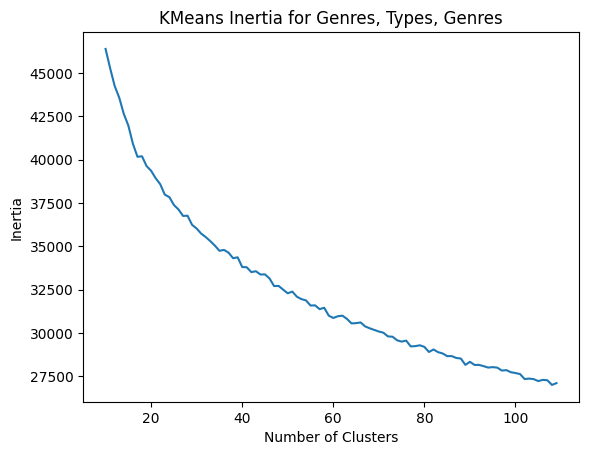

In [16]:
cluster(animes_ohe.iloc[:,8:], 10, 110, "KMeans Inertia for Genres, Types, Genres")

In [14]:
animes_ohe2 = animes_ohe.copy(deep=True)
animes_ohe2.iloc[:,52:] = animes_ohe.iloc[:,52:]*2

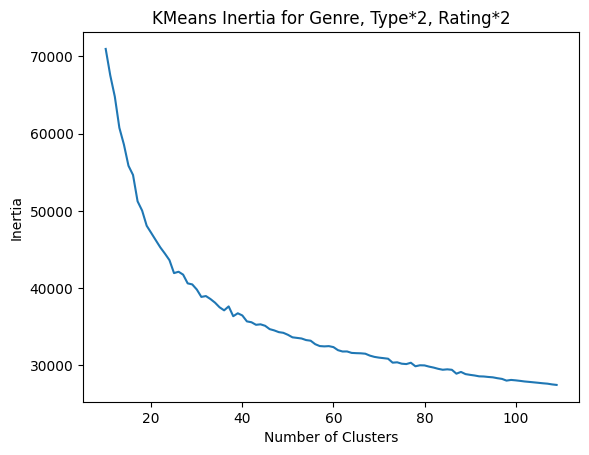

In [18]:
cluster(animes_ohe2.iloc[:,8:], 10, 110, "KMeans Inertia for Genre, Type*2, Rating*2")

In [15]:
animes_ohe.Source = animes_ohe["Source"].replace("Other", "Unknown")
animes_ohe = pd.get_dummies(animes_ohe, columns=["Source"], dtype="int")
animes_ohe["Episodes_scaled"] = animes_ohe.Episodes/max(animes_ohe.Episodes)
animes_ohe["Episodes_scaled"] = animes_ohe["Episodes_scaled"].fillna(0)

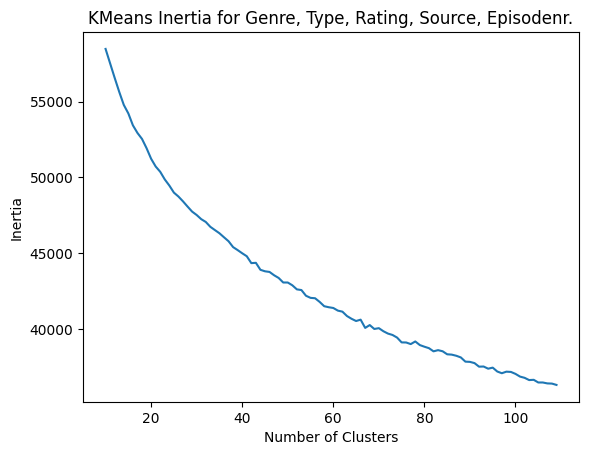

In [22]:
cluster(animes_ohe.iloc[:,7:], 10, 110, "KMeans Inertia for Genre, Type, Rating, Source, Episodenr.")

In [16]:
animes_ohe = animes_ohe.drop(["Unknown", "Type_Unknown", "Source_Unknown", "Rating_Unknown"], axis=1)

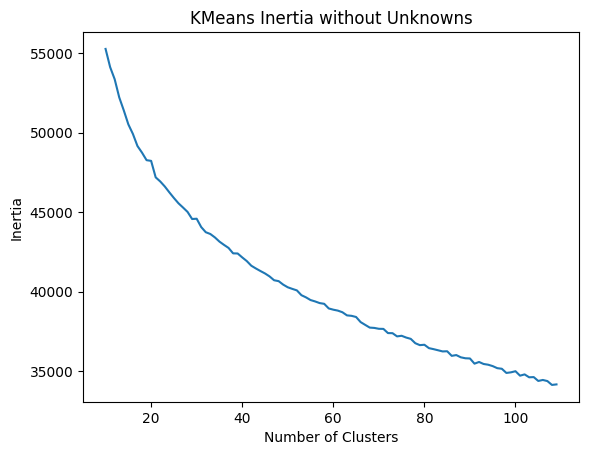

In [24]:
cluster(animes_ohe.iloc[:,7:], 10, 110, "KMeans Inertia without Unknowns")

In [17]:
animes_ohe2 = animes_ohe.copy(deep=True)
animes_ohe2.iloc[:,50:62] = animes_ohe2.iloc[:,50:62] * 2
animes_ohe2 = animes_ohe2.iloc[:,7:]

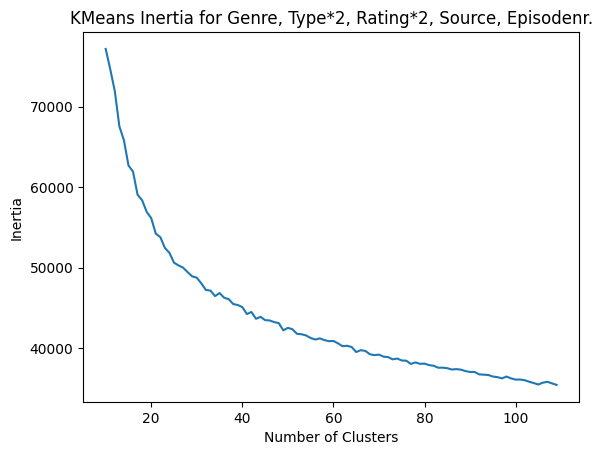

In [27]:
cluster(animes_ohe2, 10, 110, "KMeans Inertia for Genre, Type*2, Rating*2, Source, Episodenr.")

## Silhouette Score and Cluster Sizes for Cluster Size 25

In [18]:
kmeans = KMeans(n_clusters=25, init="k-means++", random_state=42, n_init=10)
kmeans.fit(animes_ohe2)
print(f"Silhoutte Score: {silhouette_score(animes_ohe2, kmeans.labels_)}")
_, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
for k in range(25):
    print(f"{k, cluster_sizes[k]}")

Silhoutte Score: 0.3303440092980596
(0, 428)
(1, 541)
(2, 1292)
(3, 1119)
(4, 1287)
(5, 813)
(6, 175)
(7, 579)
(8, 1017)
(9, 1107)
(10, 1183)
(11, 796)
(12, 287)
(13, 487)
(14, 634)
(15, 763)
(16, 706)
(17, 421)
(18, 426)
(19, 175)
(20, 688)
(21, 1037)
(22, 279)
(23, 796)
(24, 526)


## Visualisation in 3 dimensions

In [19]:
animes_cluster = pd.DataFrame(PCA(n_components=3, random_state=42).fit_transform(animes_ohe2))
animes_cluster["anime_id"] = animes_ohe2.index
animes_cluster = animes_cluster.set_index("anime_id")

In [20]:
kmeans = KMeans(n_clusters=25, init="k-means++", random_state=42, n_init=10)
animes_cluster["cluster"] = kmeans.fit_predict(animes_ohe2)
animes_cluster

,0,1,2,cluster
anime_id,,,,
1,0.709157,-0.907121,-1.382172,13
5,-0.306966,0.040659,0.719110,1
6,2.168880,-0.931708,-0.461970,5
7,1.774370,-0.929087,-0.418809,20
8,0.709326,-0.826216,-1.489099,7
...,...,...,...,...
48481,-0.178058,0.169044,0.288478,0
48483,0.678533,-0.749217,-1.364593,21
48488,0.518813,-0.611637,-1.557153,13


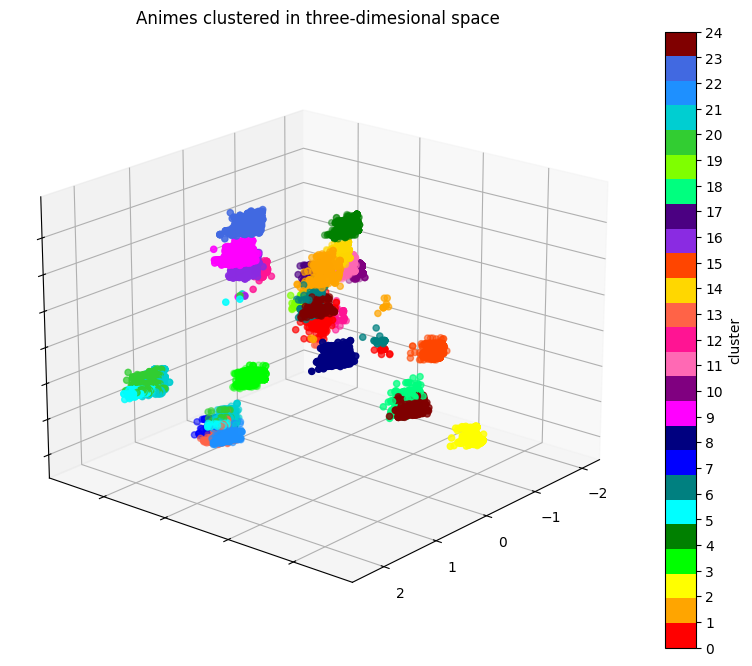

In [58]:
cmap = ListedColormap(['#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#008000',
                       '#00FFFF', '#008080', '#0000FF', '#000080', '#FF00FF',
                       '#800080', '#FF69B4', '#FF1493', '#FF6347', '#FFD700',
                       '#FF4500', '#8A2BE2', '#4B0082', '#00FF7F', '#7FFF00',
                       '#32CD32', '#00CED1', '#1E90FF', '#4169E1', '#800000'])

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(animes_cluster[0], animes_cluster[1], animes_cluster[2], c=animes_cluster["cluster"].to_numpy(), cmap=cmap)
ax.set_title("Animes clustered in three-dimesional space")
ax.xaxis.set_tick_params(labelright=False)
ax.yaxis.set_tick_params(labelbottom=False)
ax.zaxis.set_tick_params(labelleft=False)
colorbar = plt.colorbar(scatter, ax=ax, ticks=np.arange(25), label="cluster")

colorbar.set_ticklabels(['{}'.format(i) for i in range(25)])

ax.view_init(elev=20, azim=40)
plt.show()
